# Project 04: k-means Clustering
#### created by group number 3:
#### Marvin Mayer, Yvonne Sokolowski, Fabian Krämer and Alisa Mazur


This Jupyter Notebook is divided into different parts containing all the code used for the "Project 04: k-means Clustering" of group nr. 3.

1. Loading Data<br/>
    1.1 Initialize array with random values<br/>
    1.2 Initialize array through PCA<br/> <br/>
2. Initialization of centroids<br/>
    2.1 Initialize with random data points<br/>
    2.2 Initialize with mean++ algorithm<br/> <br/>
3. Plotting of the data points and centroids
4. Functions for k-mean run through
5. mini-batch algorithm<br/><br/>
6. Methods for evaluation<br/>
    6.1 Elbow method<br/>
    6.2 Evaluation with the silhouette plot<br/> <br/>
7. Comparison with sckitlearning variants<br/>
    7.1 k-mean with random initialization<br/>
    7.2 k-mean with mean++ initialization<br/>
    7.3 mini-batch with random initialization<br/>
    7.4 mini-batch with mean++ initialization<br/> <br/>
8. Main function 

### Import all the necessarry packages

In [177]:
#Packages needed for our code
import numpy as np
import random 
import matplotlib.pyplot as plt
import math
import copy
import time
from sklearn.decomposition import PCA
import scanpy as sc

#For comparison
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

## 1.) Loading data

### 1.1.) Initialize array with random values

The following code is used to generate random data points for testing purpose. The function builds a specific number of data points for a given number of clusters around a random middle point. Additionally you can specify in the `main()` function the distribution the points should have around the center. 

In [203]:
def init_array_random(array, cluster_guessed, number_of_points, distribution):
    
    #generate x-values
    data_x_cluster = []
    for counter_cluster in range(0, cluster_guessed):
        
        middle = random.uniform(0,100)
        print("X-value of perfect centroid nr." + str(counter_cluster+1) + " is: " + str(middle))
        left = middle - distribution
        right = middle + distribution
        
        for i in range(0, number_of_points):
            temp = random.uniform(left, right)
            data_x_cluster.append(temp)
         
    #generate y-values
    data_y_cluster = []
    for counter_cluster in range(0, cluster_guessed):
        
        middle = random.uniform(0, 100)
        print("Y-value of perfect centroid nr." + str(counter_cluster+1) + " is: " + str(middle))
        down = middle - distribution
        top = middle + distribution
        
        for i in range(0, number_of_points):
            temp = random.uniform(down, top)
            data_y_cluster.append(temp)
    
    #go through both lists and write the values into the array
    i = 0
    for counter_array, row in enumerate(array):
        row[0] = data_x_cluster[i]
        row[1] = data_y_cluster[i]
        i += 1
    
    #randomize array for mini-batch
    np.random.shuffle(array)
        
    return array

## 1.2.) Initialize array through PCA 

This function will return an array with the needed size containing the "3K PBMCs from a Healthy Donor Dataset" from 10x Genomics. The file has been downloaded and saved in the folder "Data Analysis" previously. 

In [179]:
#load data through PCA and return the array containing all the points
def load_data_through_PCA(k_mean):
    
    #read the data
    adata = sc.read_10x_mtx(
        r'C:\Users\user\Desktop\Data Analysis\filtered_gene_bc_matrices\hg19', 
        var_names='gene_symbols', # use gene symbols for the variable names (variables-axis index)
        cache=True)   

    x = adata._X.todense()

    p = PCA(n_components = 2)
    p.fit(x)
    x_transformed = p.transform(x)
    
    down, side = x_transformed.shape

    #initialize array
    array = np.zeros((down, k_mean + 3))
    
    i = 0
    for counter_array, row in enumerate(array):
        row[0] = x_transformed[i, 0]
        row[1] = x_transformed[i, 1]
        i += 1
        
    return array

# 2.) Initialization of centroids 

### 2.1.) Initialize with random data points

Initialize centroids by picking the x- and y- values of random data points.

In [180]:
def init_centroids_random(array, centroids):
    down, wide = array.shape
    counter_number = 1
    for counter, row in enumerate(centroids):
        point = int(random.uniform(0, down-1))
        row[0] = array[point, 0]
        row[1] = array[point, 1]
        row[7] = counter_number
        counter_number += 1
        
    return centroids

### 2.2.) Initialize with mean++ algorithm

The algorithm works as follows:
1. Choose one center uniformly from among the data points.
2. For each data point x, compute D(x), distance between x and the nearest center that has already been chosen.
3. Choose one new data point at random as new center, using a weighted probability distribution where a point x is chosen with probability proportional to D(x)².
4. Repeat Steps 2 and 3 until k centers have been chosen.

In [181]:
#take maxixmum score of weighted distances² as a new centroid point
def new_centroid(array_copy, counter_already_chosen, centroids):
    
    #get the max. distance
    max_list = np.argmax(array_copy, axis=0)
    row = max_list[3]
    centroids[counter_already_chosen, 0] = array_copy[row, 0]
    centroids[counter_already_chosen, 1] = array_copy[row, 1]
    return centroids
    
#compute weighted distance   
def sum_up_and_weight(array_copy):
    
    sum_distance = 0
    #sum up distances 
    for counter_array, row in enumerate(array_copy):
        sum_distance += row[3]
    
    sum_distance_square = sum_distance**2
        
    #weightens distance
    for counter_array, row in enumerate(array_copy):
        row[3] = row[3] / sum_distance_square
        
    return array_copy
    
    
#measures distance between a data x-/ y-value and centroid x-/ y-value and returns distance²
def distance_to_point_square(x, y, x_centroid, y_centroid):
    
    del_x = x-x_centroid 
    del_y = y-y_centroid
    del_x = -del_x if del_x<0 else del_x
    del_y = -del_y if del_y<0 else del_y
    distance = del_x**2 + del_y**2
        
    return distance

#measure distance to each centroid and remember closest centroid + distance²
def measure_distance_and_centroid(array_copy, centroids):
    for counter_array, row in enumerate(array_copy):

        #measure distance to each centroid
        for counter_centroid, value in enumerate(centroids):
            distance_square = distance_to_point_square(row[0], row[1], value[0], value[1])
            value[2] = distance_square
            
        #get index of closest centroid and write it into array + distance
        min_list = np.argmin(centroids, axis=0)
        
        #min_list[2] = point of the closest centroid
        #min_list[1] = is the same point as referred
        row[2] = centroids[min_list[2], 7]
        row[3] = centroids[min_list[2], 2]
        
    return array_copy


#initialization of centroids with mean++ algorithm
def init_centroids_mean(array, centroids, k_mean):    
   
    #take first centroid randomly from dataset
    max_number, temp = array.shape
    max_number -= 1
    first = random.randint(0, max_number)
    centroids[0, 0] = array[first, 0]
    centroids[0, 1] = array[first, 1]
    
    array_copy = copy.deepcopy(array)
    #because we only need x , y , closest centroid, distance²/ weighted distance² for the array:
    #splice array to get the first 4 columns of every data point
    array_copy = array_copy[:,:4]

    #write the number of the centroids into the array of centroids
    counter_number = 1
    for counter, row in enumerate(centroids):
        row[7] = counter_number
        counter_number += 1
     
    counter_already_chosen = 1

    #do the mean++ algorithm until all of the centroids are assigned to one data point
    while counter_already_chosen < k_mean:
        
        measure_distance_and_centroid(array_copy, centroids)
        sum_up_and_weight(array_copy)
        new_centroid(array_copy, counter_already_chosen, centroids)
        
        counter_already_chosen += 1
    
    #reset values occupied in centroids
    for counter, row in enumerate(centroids):
        row[2] = 0
    
    return centroids

## 3.) Plotting of the data points and centroids

A function which plots all data points and centroids. The data points are coloured in the same colour as their closest centroid.

In [182]:
def plot_array_and_centroids(array, centroids):
    
    #label plot
    plt.xlabel('X-value')
    plt.ylabel('Y-value')
    
    #dictionairy for colours 
    dictionairy = {0 : 'black',
                   1 : 'darkblue', 
                   2 : 'darkorange', 
                   3 : 'darkgreen', 
                   4 : 'darkgrey', 
                   5 : 'aqua', 
                   6 : 'lime', 
                   7 : 'steelblue',
                   8 : 'brown', 
                   9 : 'fuchsia', 
                  10 : 'gold'}
    
    #plot data points with the colour of their closest centroid
    for counter, value in enumerate(array):
        wert = value[2]
        farbe = dictionairy[wert]
        plt.plot(value[0],value[1], marker = 'o', color = farbe, markersize=3)
       
    
    #plot centroids    
    for counter_centroids, row in enumerate(centroids):
        wert = row[7]
        farbe = dictionairy[wert]
        plt.plot(row[0],row[1], marker = 'x', color = farbe, markersize=7, markerfacecolor = 'k', markeredgewidth=1.5)
        
    plt.show()

# 4.) Functions for k-mean run through

Measure the distance of a x-/ y-value of a data point and the x-/ y-value of a centroid.

In [183]:
def distance_to_point(x, y, x_centroid, y_centroid):
    
    del_x = x-x_centroid 
    del_y = y-y_centroid   
    del_x = -del_x if del_x<0 else del_x
    del_y = -del_y if del_y<0 else del_y
    
    distance = math.sqrt(del_x**2 + del_y**2)
    
    return distance

Measures for every data point the distance to every centroid and writes it into array.

In [184]:
def measure_distance(array, centroids):
    
    for counter_array, row_array in enumerate(array):
        for counter_centroids, row_centroids in enumerate(centroids):
            
            #measure distance
            row_array[counter_centroids + 3] = distance_to_point(row_array[0], row_array[1], row_centroids[0], row_centroids[1])
            
    return array

Define the closest centroid of each data point by comparing the distances to the centroids.

In [185]:
def closest_centroid(array, k_mean):
    #deep copy of array
    array_copy = copy.deepcopy(array)
    
    height, distance_count = array_copy.shape
    #slicing array, so only distances are in new array
    #with only the columns of the distances (from 3 until the number of centroids analyzed)
    array_copy = array_copy[:,3:k_mean+3]
    
    height, distance_count = array_copy.shape
    #if the observed centroid is the closest one, write the corresponding number into array
    while distance_count != 0:
        for counter_array, row in enumerate(array_copy):
            if row[distance_count-1] == min(row):
                array[counter_array, 2] = distance_count
        
        distance_count -= 1
 
    return array

This function is needed for the reassigning of the centroids. It sums up the x-/ y-values to their closest centroid as well as increasing the counter in the centroid array.

In [186]:
def gather_values_from_array(array, centroids):
    for counter_array, value in enumerate(array):
        
        k = int(value[2]) - 1
        centroids[k,4] += 1
        centroids[k,5] += value[0]
        centroids[k,6] += value[1]
        
    return array

Reassigning the centroids by dividing the x-/ y-values of one centroid through the sum of x-/ y-values of all to this centroid assigned data points.

In [187]:
 def reassign_centroid(array, centroids):

    gather_values_from_array(array, centroids)

    for counter_centroids, row in enumerate(centroids):
        #write old values into new spot
        row[2] = row[0]
        row[3] = row[1]
        
        #if there are points assigned to each centroid (counter != 0)
        #the centroids are reassigned (new_x = score_x / counter)
        if row[4] != 0:
            new_x = row[5] / row[4]
            new_y = row[6] / row[4]
            row[0] = new_x
            row[1] = new_y
        
        #resets values for the next reassign_centroid() / k-mean runthrough
        row[4] = 0
        row[5] = 0
        row[6] = 0

    return centroids

In this function the evaluation of the change by the centroids is evaluated. By comparing the coordinates of the centroids before and after calling the function `reassing_centroid()`, the code is able to determine how many centroids have changed less than the `min_value`. If the change of all centroids is lower than the `min_value` the return statement will be true otherwise it will be false.

In [188]:
def evaluate_score(centroids, k_mean_for_init_centroids):   
    
    for counter_centroids, row in enumerate(centroids):
        
        #distance=old value-new value
        distance_x = row[2]-row[0]
        distance_y = row[3]-row[1]
        
        #absolute value  
        distance_x = -distance_x if distance_x<0 else distance_x
        distance_y = -distance_y if distance_y<0 else distance_y
        distance = math.sqrt(distance_x**2 + distance_y**2)
         
        #for less than 0.0005 change in the distance of the centroid it writes true into collumn nr.8
        min_value = 0.0005
        if distance < min_value:
            row[8] = 1 # == true
        else: 
            row[8] =  0 # == false
    
    
    #if the complete collumn nr.8 of the centroids is filled with 1
    #the sum of the value those values must be euqal to k_mean in this run-through
    summe = 0
    
    for counter_centroids, row in enumerate(centroids):
        summe += row[8]
    
    if summe == k_mean_for_init_centroids:
        return 1# == true
    else:
        return 0# == false

# 5.) mini-batch algorithm
The algorithm iterates between two major steps, similar to k-mean.
1. In the first step, samples are drawn from the dataset, to form a mini-batch. These are then assigned to the nearest centroid
2. In the second step, the centroids are updated. In contrast to k-mean, this is done on a per-sample basis. For each sample in the mini-batch, the assigned centroid is updated by taking the streaming average of the sample and all previous samples assigned to that centroid. This has the effect of decreasing the rate of change for a centroid over time. 

In [201]:
def function_mini_batch(array, centroids, k_mean_for_init_centroids, number_of_mini_batch):
    
    runter, breit = array.shape

    #determine the size for each batch
    if runter%number_of_mini_batch == 0:
        per_batch = int(runter/number_of_mini_batch)    
    else:
        runter -= 1
        per_batch = int(runter/number_of_mini_batch)

    #counter is starting point the array for each batch
    counter = 0
       
    #loop for mini-batch
    for i in range (0, number_of_mini_batch):

        #make batch out of the whole data set
        array_copy = copy.deepcopy(array)
        array_copy = array_copy[counter : counter+per_batch]    
        
        #for each data point, the closest centroid is measured
        measure_distance(array_copy, centroids)            
        closest_centroid(array_copy, k_mean_for_init_centroids)
    
        for counter_array, row in enumerate(array_copy):
            
            #update catched points for this centroid
            closest_centroid_number = int(row[2]-1)
            centroids[closest_centroid_number, 4] += 1
            
            #learning rate = 1 / number of already assigned data points for this centroid
            learning_rate = 1 / centroids[closest_centroid_number, 4]
        
            #take gradient step: (1-learning rate) * current x/y-value of centroid + learning rate * new data point
            centroids[closest_centroid_number, 0] = (1-learning_rate) * centroids[closest_centroid_number, 0] + learning_rate * row[0]
            centroids[closest_centroid_number, 1] = (1-learning_rate) * centroids[closest_centroid_number, 1] + learning_rate * row[1]
            
            array[counter+counter_array, 2] = row[2]            
            
            
        #sum up counter for next batch run through
        counter += per_batch

    return array, centroids

# 6.) Methods for evaluation

## 6.1.) Elbow method
Evaluation of the run through with the elbow method. The function sums up the total sum of square (TSS) of each centroid and returns this value.

In [190]:
def evaluate_score_for_elbow(array, centroids):
    
    for counter_centroids, row_centroids in enumerate(centroids):
        for counter_array, row_array in enumerate(array):
            
            #if the number of the current centroid is the closest centroid of this point
            if row_centroids[7] == row_array[2]:
                
                #measure the distance of this point and the centroid and add the TSS in the centroid array
                row_centroids[4] += distance_to_point_square(row_array[0], row_array[1], row_centroids[0], row_centroids[1])
                
    #sum up the TSS of all centroids
    sum_TSS = 0
    for counter, row in enumerate(centroids):
        sum_TSS += row[4]
        
        #reset the place in the centroid array for next run through
        row[4] = 0
    
    return sum_TSS

## 6.2.) Evaluation with the silhouette plot
The silhouette plot compares the distances of each data point of one centroid towards the distance of the closest centroids and their respective data points to form the value for `s_i`.
`a_i` describes the sum of distances from one centroid to every to this centroid assigned data points through the number of points assigned to it.
`b_i` takes a look at the closest centroid next to the one analyzed in this cycle and calculates the sum of distances to this centroid assigned data points.
The calculation of `s_i` depends on which value - `a_i` or `b_i` - is bigger, so a value between 0 and 1 is calculated and returned to the main function.

In [191]:
#function to get the number of the centroid out of a tupel
def getKey(item):
    return item[1]

#evaluation of graph through silhouette plot
def silhouette_evaluation(array, centroids, k_mean):
    
    #list of s_i values for all the centroids
    list_of_values_s_i = []
    
    for counter_centroids, row_centroids in enumerate(centroids):
        
        #initialize the values needed for a_i
        counter_data_per_centroid = 0
        summe = 0
        
        #go through each data point
        for counter_array, row_array in enumerate(array):
            
            #if the number of the centroid is equal to the closest centroid:
            #add the number of counts and sum up the distance of each point
            if counter_centroids+1 == row_array[2]:
                
                counter_data_per_centroid += 1
                summe += distance_to_point(row_centroids[0], row_centroids[1], row_array[0], row_array[1])

        #calculate a_i
        try:
            a_i = summe/counter_data_per_centroid
        except: #if nor points are assigned to this centroid
            a_i = 0
        
        list_for_b_i = []

        #if there are more than one centroid, run the following code
        if k_mean > 1:
            for i in range(0, k_mean):
                
                #if the analyzed centroid is different from the current centroid
                if row_centroids[0] != centroids[i, 0] and row_centroids[1] != centroids[i, 1]: 
                    
                    #measure distance between centroids and append list
                    distance = distance_to_point(row_centroids[0], row_centroids[1], centroids[i, 0], centroids[i, 1])
                    list_for_b_i.append((distance, i))
            
            #get index of closest centroid and write it into array + distance
            min_list = sorted(list_for_b_i, key=getKey)
            
            #determine smallest value and remeber the number of the centroid
            smallest_value, nummer_centroid = min_list[0]
        
            #measure all the distances of b_i
            counter_data_per_centroid = 0
            summe = 0 
            
            #for each data point
            #if the data point goes with the closest centroid, measure the distance and sum it up
            for counter_array, row_array in enumerate(array):
                if nummer_centroid+1 == row_array[2]:
                    counter_data_per_centroid += 1
                    summe += distance_to_point(row_centroids[0], row_centroids[1], row_array[0], row_array[1])
                
            #calculate b_i
            try:
                b_i = summe/counter_data_per_centroid
            except: #if nor points are assigned to this centroid
                b_i = 0

            #the evaluation of s_i is determend by the value of a_i and b_i
            try:
                if a_i > b_i:
                    s_i = (b_i - a_i) / a_i
                else:
                    s_i = (b_i - a_i) / b_i
            except:
                s_i = 0
            list_of_values_s_i.append(s_i)
        else:
            list_of_values_s_i.append(1)
    
    #determine the value for all centroids and give the value back 
    sum_s_i = 0
    for i in range(0, len(list_of_values_s_i)):
        sum_s_i += list_of_values_s_i[i]

    final_value = sum_s_i / len(list_of_values_s_i)
    
    return final_value

# 7.) Comparison with sckitlearning variants
## 7.1.) k-mean with random initialization
K-mean run through of sckitlearning variant with random initialization of centroids.

In [192]:
def k_mean_with_random_init_sckitlearning(array, centroids, k_mean_for_init_centroids):

    x_transformedx = array[:,0:2]
    model = KMeans(n_clusters = k_mean_for_init_centroids, init='random').fit(x_transformedx)

    labels = model.labels_
    j = 0
    for counter, row in enumerate(x_transformedx):
        array[counter, 0] = row[0]
        array[counter, 1] = row[1]
        array[counter, 2] = labels[j]+1
        j += 1
    
    cluster = model.cluster_centers_
    
    for counter, row in enumerate(cluster):
        centroids[counter, 0] = row[0]
        centroids[counter, 1] = row[1]

    return array, centroids

## 7.2.) k-mean with mean++ initialization
K-mean run through of sckitlearning variant with centroids initialized with the mean++ algorithm.

In [193]:
def k_mean_with_meansplusplus_init_sckitlearning(array, centroids, k_mean_for_init_centroids):
    
    x_transformedx = array[:,0:2]
    model = KMeans(n_clusters = k_mean_for_init_centroids, init='k-means++').fit(x_transformedx)

    labels = model.labels_
    j = 0
    for counter, row in enumerate(x_transformedx):
        array[counter, 0] = row[0]
        array[counter, 1] = row[1]
        array[counter, 2] = labels[j]+1
        j += 1
    
    cluster = model.cluster_centers_
    
    for counter, row in enumerate(cluster):
        centroids[counter, 0] = row[0]
        centroids[counter, 1] = row[1]

    return array, centroids

## 7.3.) mini-batch with random initialization
mini-batch run through of sckitlearning variant with random initialization of centroids.

In [194]:
def mini_batch_with_random_init_sckitlearning(array, centroids, k_mean_for_init_centroids, number_of_mini_batch):
    
    x_transformedx = array[:,0:2]
    model = MiniBatchKMeans(n_clusters=k_mean_for_init_centroids, init='random', batch_size=number_of_mini_batch).fit(x_transformedx)

    labels = model.labels_
    j = 0
    for counter, row in enumerate(x_transformedx):
        array[counter, 0] = row[0]
        array[counter, 1] = row[1]
        array[counter, 2] = labels[j]+1
        j += 1
    
    cluster = model.cluster_centers_
    
    for counter, row in enumerate(cluster):
        centroids[counter, 0] = row[0]
        centroids[counter, 1] = row[1]

    return array, centroids

## 7.4.) mini-batch with mean++ initialization
mini-batch run through of sckitlearning variant with centroids initialized with the mean++ algorithm.

In [195]:
def mini_batch_with_meansplusplus_init_sckitlearning(array, centroids, k_mean_for_init_centroids, number_of_mini_batch):
    
    x_transformedx = array[:,0:2]
    model = MiniBatchKMeans(n_clusters=k_mean_for_init_centroids, init='k-means++', batch_size=number_of_mini_batch).fit(x_transformedx)

    labels = model.labels_
    j = 0
    for counter, row in enumerate(x_transformedx):
        array[counter, 0] = row[0]
        array[counter, 1] = row[1]
        array[counter, 2] = labels[j]+1
        j += 1
    
    cluster = model.cluster_centers_
    
    for counter, row in enumerate(cluster):
        centroids[counter, 0] = row[0]
        centroids[counter, 1] = row[1]

    return array, centroids

# 8.) Main function:
Our main function consists of five parts: <br/>
First we define the parameters needed for the initialization of the array containing the data points as well as different ways of initializing the array - random or through PCA.<br/>
Afterwards the initialization of the centroids takes place. This is done by initializing through taking random data points or by the mean++ algorithm. <br/>
Next up the code executes the k-mean or the miniBatch with different number of centroids (max. number of centroids is 10 otherwise it will result into an error in the `plot_array()` function). <br/>
You can also choose the variants of the sckitlearning methods for comparison for one run through. If you do so, don't forget to disable the function/ parameter for the run through of our own written code of k-mean and mini-batch. <br/>
Afterwards the time for one run through is being measured as well as different functions for the evaluation will be applied.


X-value of perfect centroid nr.1 is: 26.379330394913215
X-value of perfect centroid nr.2 is: 58.59741458444259
X-value of perfect centroid nr.3 is: 72.78658194276116
X-value of perfect centroid nr.4 is: 88.51281209804391
X-value of perfect centroid nr.5 is: 12.099568673363127
Y-value of perfect centroid nr.1 is: 75.19034793309038
Y-value of perfect centroid nr.2 is: 21.86768173811985
Y-value of perfect centroid nr.3 is: 50.43658664519414
Y-value of perfect centroid nr.4 is: 18.48416687777039
Y-value of perfect centroid nr.5 is: 91.91715568622837

Time it took for the result for one run through with 2 centroids: 0.15451383590698242 seconds.

Final Centroids after one run through:
1. : 73.43417221007452 | 30.101699732406736
2. : 19.02428667113766 | 83.58165934638467


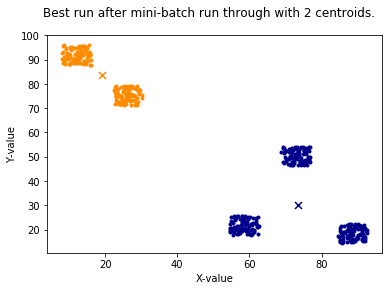


Time it took for the result for one run through with 3 centroids: 0.11426377296447754 seconds.

Final Centroids after one run through:
1. : 73.58814910435737 | 20.002157686836274
2. : 19.02428667113766 | 83.58165934638467
3. : 73.12621842150844 | 50.30078382354758


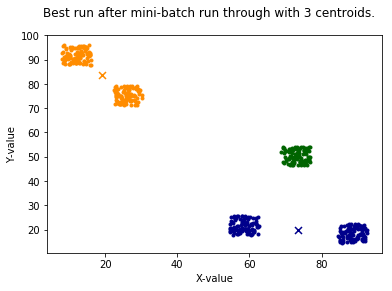


Time it took for the result for one run through with 4 centroids: 0.1197669506072998 seconds.

Final Centroids after one run through:
1. : 73.12621842150844 | 50.30078382354758
2. : 19.02428667113766 | 83.58165934638467
3. : 88.77688760003484 | 18.45841067035907
4. : 58.39941060868008 | 21.54590470331348


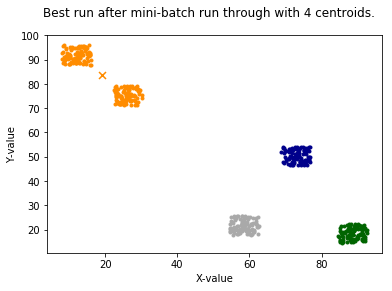


Time it took for the result for one run through with 5 centroids: 0.1237328052520752 seconds.

Final Centroids after one run through:
1. : 88.77688760003484 | 18.45841067035907
2. : 12.172518773266134 | 91.78651354203554
3. : 73.12621842150844 | 50.30078382354758
4. : 58.39941060868008 | 21.54590470331348
5. : 25.87605456900921 | 75.37680515073394


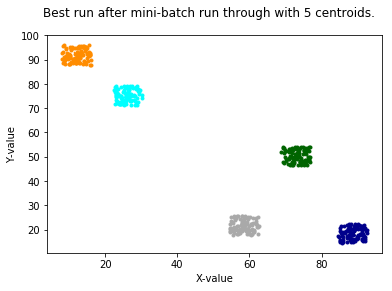


Time it took for the result for one run through with 6 centroids: 0.16350221633911133 seconds.

Final Centroids after one run through:
1. : 73.12621842150844 | 50.30078382354758
2. : 10.665052412514488 | 92.61631238302378
3. : 88.77688760003484 | 18.45841067035907
4. : 58.39941060868008 | 21.54590470331348
5. : 25.87605456900921 | 75.37680515073394
6. : 13.872427648156266 | 90.85078293411271


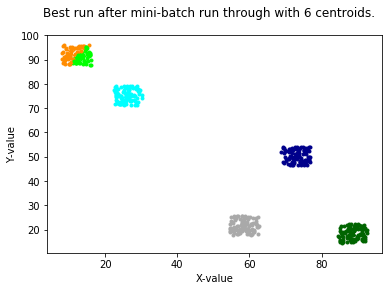


Time it took for the result for one run through with 7 centroids: 0.26601362228393555 seconds.

Final Centroids after one run through:
1. : 12.172518773266134 | 91.78651354203554
2. : 88.77688760003484 | 18.45841067035907
3. : 72.76110074504076 | 52.37505034847006
4. : 58.39941060868008 | 21.54590470331348
5. : 26.41231980795412 | 73.2101289106153
6. : 73.45000202139477 | 48.46133992408806
7. : 25.471503599278826 | 77.01131529678847


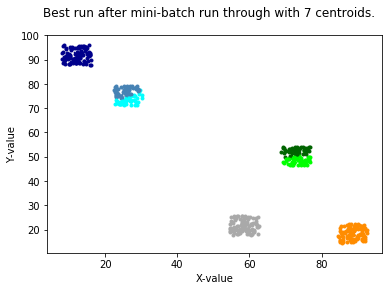


Time it took for the result for one run through with 8 centroids: 0.20825433731079102 seconds.

Final Centroids after one run through:
1. : 12.172518773266134 | 91.78651354203554
2. : 88.77688760003484 | 18.45841067035907
3. : 72.76110074504076 | 52.37505034847006
4. : 56.87543692943543 | 20.58039091384242
5. : 26.41231980795412 | 73.2101289106153
6. : 73.45000202139477 | 48.46133992408806
7. : 25.471503599278826 | 77.01131529678847
8. : 59.86362061422882 | 22.473555206922896


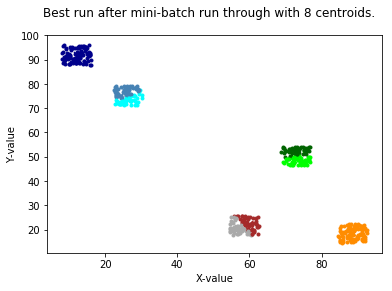


Time it took for the result for one run through with 9 centroids: 0.2691650390625 seconds.

Final Centroids after one run through:
1. : 11.064434587532487 | 90.12181684577894
2. : 88.77688760003484 | 18.45841067035907
3. : 72.76110074504076 | 52.37505034847006
4. : 56.87543692943543 | 20.58039091384242
5. : 26.41231980795412 | 73.2101289106153
6. : 73.45000202139477 | 48.46133992408806
7. : 25.471503599278826 | 77.01131529678847
8. : 59.86362061422882 | 22.473555206922896
9. : 13.422060514625334 | 93.66372471015472


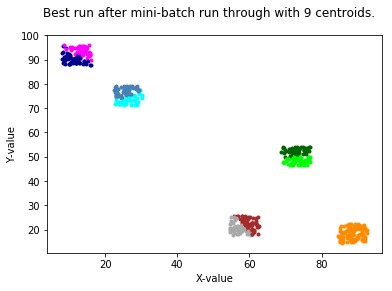


Time it took for the result for one run through with 10 centroids: 0.29415273666381836 seconds.

Final Centroids after one run through:
1. : 25.036150120276485 | 74.22895228618016
2. : 90.32667770583899 | 17.991183851761853
3. : 72.76110074504076 | 52.37505034847006
4. : 56.87543692943543 | 20.58039091384242
5. : 10.665052412514488 | 92.61631238302378
6. : 13.872427648156266 | 90.85078293411271
7. : 73.45000202139477 | 48.46133992408806
8. : 59.86362061422882 | 22.473555206922896
9. : 86.9575687801777 | 19.0068943269732
10. : 27.506457322431537 | 77.60499012310316


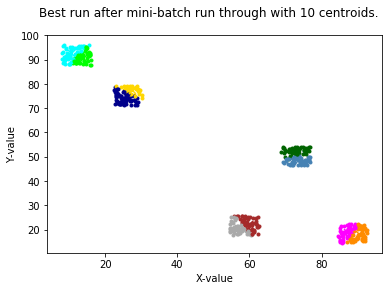

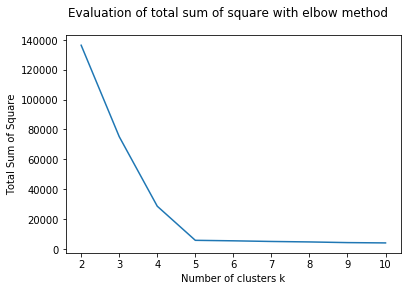

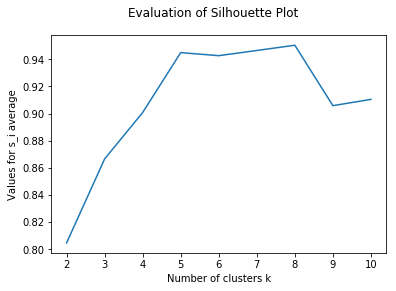

In [204]:
def main():
    
    #define the starting point of analyzed clusters
    k_mean_start_point = k_mean_for_init_centroids = 2
    
    #define the end point of analyzed clusters
    k_mean_max = 10
    
    #how many cluster should data have
    cluster_guessed = 5

    #distribution of points around 1 cluster
    distribution = 4

    #number of points each cluster should have
    number_of_points = 100
    
    #how many mini batches? --> for mini-batch (own version and sckitlearning version)
    number_of_mini_batch = 5

    #create array of data points
    #style: cluster_guess + 3 dimension because: x-value, y-value, the closest centroid, distance to centroids, ....
    array = np.zeros((cluster_guessed*number_of_points, k_mean_max + 3))

    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
        Choose between random initialized array of data points or array initialized through PCA.
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    #choose which data should be taken
    #first one is random distributed data points around different middle points
    array = init_array_random(array, cluster_guessed, number_of_points, distribution)
    #array = load_data_through_PCA(k_mean_max)

    #enable plotting
    plt.figure()
    
    #list to gather values for silhouette plot
    list_for_silhouette_average = []
    
    #list to gather values for elbow method
    list_for_elbow = []


    #k mean normal run through as well as mini-batch
    #with varying
    for i in range(k_mean_for_init_centroids, k_mean_max+1):

        #create array of centroids and initialize
        #style:"cur_x", "cur_y", "old_x", "old_y", "counter", "score_x", "score_y", "number of centroid", "is changing koordinates?"
        centroids = np.zeros((k_mean_for_init_centroids, 9))
        
        """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
            Choose between random initialized centroids or centroids initialized with the mean++ algorithm.
        """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
        #uncomment for different initialization of centroids
        #centroids = init_centroids_random(array, centroids)
        centroids = init_centroids_mean(array, centroids, k_mean_for_init_centroids)
        
        
        start = time.time()
        
        """""""""""""""""""""""""""""""""""""""""""""""""""
            Choose between mini-batch and k-mean run through.
        """""""""""""""""""""""""""""""""""""""""""""""""""
        #uncomment for mini-batch run through
        function_mini_batch(array, centroids, k_mean_for_init_centroids, number_of_mini_batch)
        #turn runner = 1 for k-mean run through
        runner = 0
        counter_runs = 0
                
        #while true: normal k-ean run through
        while runner:
            if k_mean_for_init_centroids == 12:
                runner = 0
                k_mean_for_init_centroids -= 1
                break
                
            measure_distance(array, centroids)            
            closest_centroid(array, k_mean_for_init_centroids)
            reassign_centroid(array, centroids)
            counter_runs += 1   
                
            if evaluate_score(centroids, k_mean_for_init_centroids):
                counter_runs -= 1
                plt.suptitle("Best run after " + str(counter_runs) + " run throughs with " + str(k_mean_for_init_centroids) + " centroids.")
                k_mean_for_init_centroids += 1
                break
                
                
            elif counter_runs == 51:
                counter_runs-=1
                print("Kmeans stopped after 50 runthroughs, because the calculations took to long")
                plt.suptitle("Best run after " + str(counter_runs) + " run throughs with " + str(k_mean_for_init_centroids) + " centroids.")
                k_mean_for_init_centroids += 1    
                break

        
        """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
            Choose between sckitlearning variants of k-means, k-means with mean++ 
            ,mini-batch and mini-beatch with mean++.
            If you want to see the results of only the sckitlearning variants,
            #comment the function_mini_batch() and set runner = 0.
        """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
        #k_mean_with_random_init_sckitlearning(array, centroids, k_mean_for_init_centroids)
        #k_mean_with_meansplusplus_init_sckitlearning(array, centroids, k_mean_for_init_centroids)
        #mini_batch_with_random_init_sckitlearning(array, centroids, k_mean_for_init_centroids, number_of_mini_batch)
        #mini_batch_with_meansplusplus_init_sckitlearning(array, centroids, k_mean_for_init_centroids, number_of_mini_batch)
        
        end = time.time()

        zeit=end-start

        print("\nTime it took for the result for one run through with " + str(k_mean_for_init_centroids) + " centroids: " + str(zeit) + " seconds.")
        
        if runner != 1:
            plt.suptitle("Best run after mini-batch run through with " + str(k_mean_for_init_centroids) + " centroids.")
            k_mean_for_init_centroids += 1
            
        
        print("\nFinal Centroids after one run through:")
        for counter, row in enumerate(centroids):
            print(str(counter+1) + ". : " + str(row[0]) + " | " + str(row[1]))
            
        """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
            Enable/ Disable Plotting of the data points and centroids after one run through
        """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
        #uncomment to plot the data points and centroids
        plot_array_and_centroids(array, centroids)
        
        list_for_silhouette_average.append(silhouette_evaluation(array, centroids, k_mean_for_init_centroids-1)) 
        list_for_elbow.append(evaluate_score_for_elbow(array, centroids))
    
    x_list = []
    for i in range(k_mean_start_point, k_mean_max+1):
        x_list.append(i)
        
    plt.xlabel("Number of clusters k")
    plt.ylabel("Total Sum of Square")
    plt.suptitle("Evaluation of total sum of square with elbow method")
    plt.plot(x_list, list_for_elbow)
    plt.show()
    
    
    plt.xlabel("Number of clusters k")
    plt.ylabel("Values for s_i average")
    plt.suptitle("Evaluation of Silhouette Plot")
    plt.plot(x_list, list_for_silhouette_average)
    plt.show()
    
main()     
